<a href="https://colab.research.google.com/github/ty-porter/arima-energy-usage/blob/master/US_Energy_Usage_SARIMA_C964.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# C964 Computer Science Capstone
## ACME Energy Cooperative SARIMA Demand Forecast Tool

---

*Author: Tyler Porter*

*Student ID: 011630194*

*Modified: January 28, 2024*

---

Welcome to ACME's demand forecast tool.

First, the historical US energy demand dataset from the last 6 years is examined.


In [2]:
import pandas as pd

CSV_URL = "https://raw.githubusercontent.com/ty-porter/arima-energy-usage/master/data/energy_usage.csv"

# Import the CSV and print out details to understand the data.
df = pd.read_csv(CSV_URL, parse_dates=["date"])
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58936 entries, 0 to 58935
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           58936 non-null  datetime64[ns]
 1   megawatthours  58936 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 921.0 KB


,date,megawatthours
0,2015-07-01 05:00:00,162827
1,2015-07-01 06:00:00,335153
2,2015-07-01 07:00:00,333837
3,2015-07-01 08:00:00,398386
4,2015-07-01 09:00:00,388954


The following plot shows that there is a row for each hour between July 1, 2015 and March 21, 2022.

The data consists of a `date` and `megawatthours` column.

<Axes: title={'center': 'US Hourly Electricity Demand (MWH)'}, xlabel='date', ylabel='Megawatt hours (MGH)'>

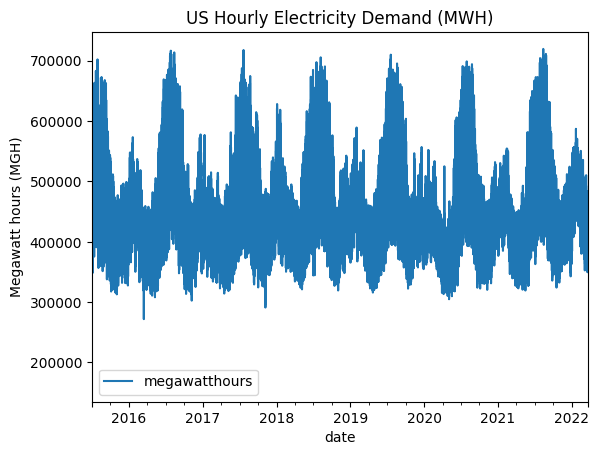

In [3]:
# Plot the raw data
df.plot(title="US Hourly Electricity Demand (MWH)", x="date", y="megawatthours", ylabel="Megawatt hours (MGH)")

ACME does not really need hourly energy demand data. Therefore, it needs to be transformed to monthly data.

Here, the demand is calculated on a monthly basis. It is assumed that there is 30 days within each month. The number of transformed rows should be roughly equal to the expected number of rows after this transformation.

In [4]:
# Hourly is too granular for this use case. Resample the data to look at monthly demand instead.
df_monthly = df.resample("1M", on="date").mean().reset_index()

print(f"Hourly dataset size: {len(df)}")
print(f"Monthly dataset size: {len(df_monthly)}")

# Value is approximate, assumes 30 days per month
hours_per_month = 30.0 * 24
print(f"Expected rows: {len(df) / hours_per_month}")
print(f"Error: {1 - len(df_monthly) / (len(df) / hours_per_month)}")

df_monthly.head()

Hourly dataset size: 58936
Monthly dataset size: 81
Expected rows: 81.85555555555555
Error: 0.010452015745893828


,date,megawatthours
0,2015-07-31,519010.240866
1,2015-08-31,490449.064516
2,2015-09-30,475740.758333
3,2015-10-31,410541.775538
4,2015-11-30,408467.400000


The new data is less noisy and is more appropriate to train the (S)ARIMA forecasting model.

Seasonality is noted as yearly (period of 12 months). SARIMA is selected as the forecast model.

<Axes: title={'center': 'US Monthly Electricity Demand (MWH)'}, xlabel='date', ylabel='Megawatt hours (MGH)'>

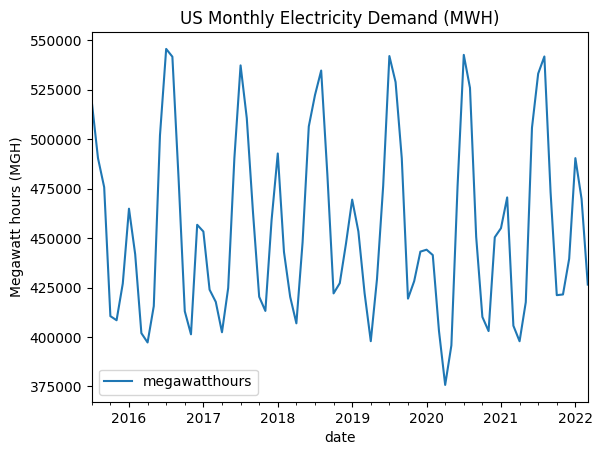

In [5]:
# Plot the new daily data.
df_monthly.plot(title="US Monthly Electricity Demand (MWH)", x="date", y="megawatthours", ylabel="Megawatt hours (MGH)")

To train, the dataset is split into test/train categories.

The train dataset will consist of the first 51 values. The test dataset will be the remainder (last 30 values).

In [6]:
msk = (df_monthly.index < len(df_monthly) - 30)
df_train = df_monthly[msk].copy()
df_test = df_monthly[~msk].copy()

To create the model, values for `p`, `d`, `q` will be selected.

These plots indicate that first-order differencing might be needed.

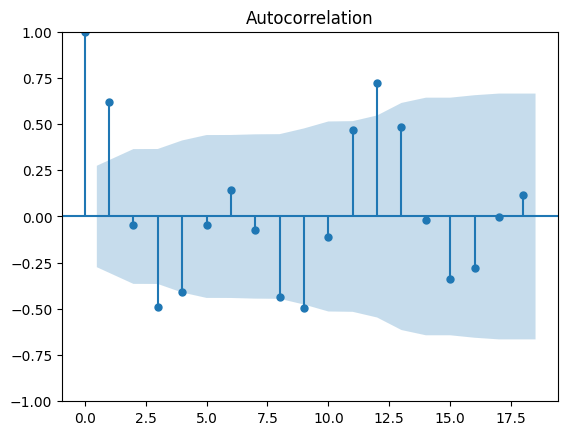

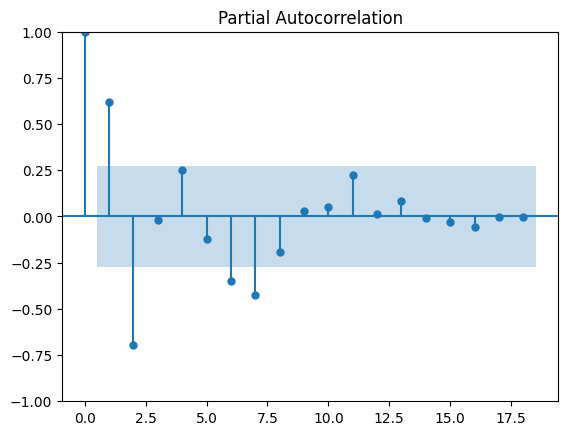

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train["megawatthours"])
pacf_original = plot_pacf(df_train["megawatthours"])

Perform first-order differencing.

Since this looks more stationary, the first order (1) is selected for the value of `d`.

<Axes: >

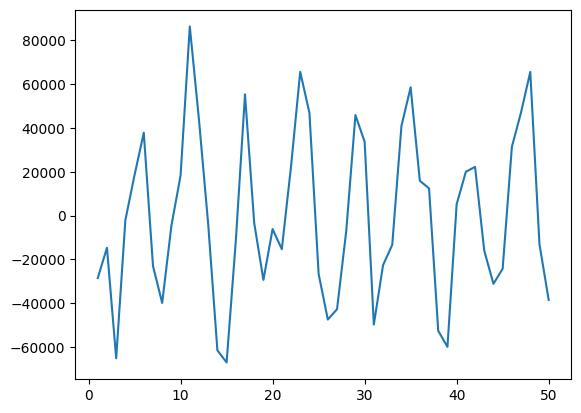

In [8]:
df_train_diff = df_train["megawatthours"].diff().dropna()
df_train_diff.plot()

Plot the ACF/PACF of the first order difference. Note the steep drop at the first index on both plots, outside of the blue confidence interval.

1 is selected for the value of `p` and `q`.

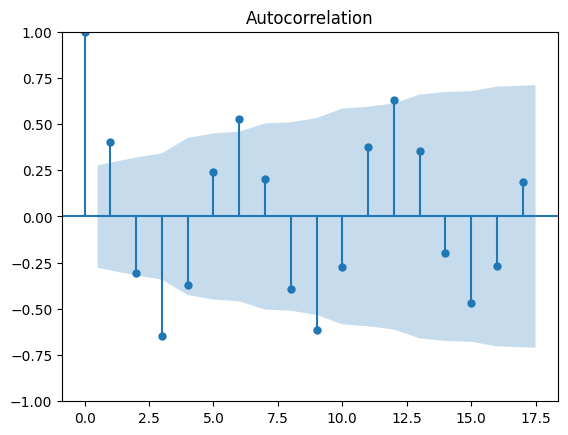

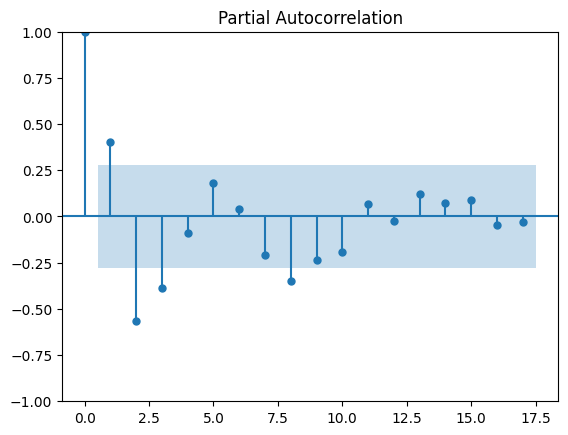

In [9]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

The model is trained on the training dataset using `p`, `d`, `q` = 1, 1, 1 with seasonality 12.

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df_train["megawatthours"], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now that the model is trained, validate the success of the prediction.

The model was trained on the initial 51 data points in the set. Now, it is compared against the training dataset containing the last 30 data points. The prediction is superimposed on the actual data.

The model is accepted as accurate with a MAPE of < 4%.

Mean Absolute Error (MAE): 14924.771964930622
Mean Absolute Percentage Error (MAPE): 0.033370676160197066
Root Mean Square Error (RMSE): 18655.953441020385


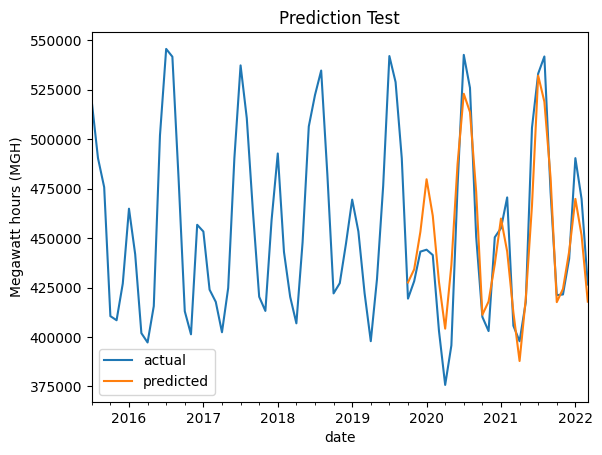

In [24]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

PREDICTION_END   = len(df_monthly)
PREDICTION_START = PREDICTION_END - len(df_test)

prediction_test = df_monthly.copy().rename(columns={"megawatthours": "actual"})

# prediction_test["predicted"] = model_fit.predict(start=PREDICTION_START)
prediction_test["predicted"] = model_fit.predict(start=PREDICTION_START, end=PREDICTION_END)
prediction_test.plot(title="Prediction Test", x="date", ylabel="Megawatt hours (MGH)")

actual = prediction_test.iloc[PREDICTION_START:]["actual"]
predicted = prediction_test.iloc[PREDICTION_START:]["predicted"]

mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Root Mean Square Error (RMSE): {rmse}')

Provide a baseline prediction for 24 months, meeting project goal for minimum of 24 months of forecasting.

,date,megawatthours,forecast
100,2023-10-31,NaN,414392.554665
101,2023-11-30,NaN,433311.644319
102,2023-12-31,NaN,459907.502597
103,2024-01-31,NaN,441428.405969
104,2024-02-29,NaN,407939.667644


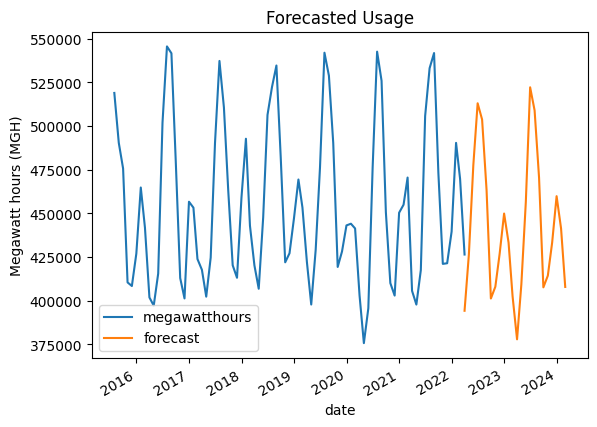

In [46]:
from pandas.tseries.offsets import DateOffset

future_dates = [df_monthly.iloc[-1]["date"] + DateOffset(months=x) for x in range(0, 24)]
df_future = pd.DataFrame(columns=df_monthly.columns)
df_future["date"] = future_dates

df_future.tail()

df_prediction = pd.concat([df_monthly, df_future]).set_index("date").reset_index()
df_prediction["forecast"] = model_fit.predict(start=len(df_monthly), end=len(df_monthly) + 24)

df_prediction.plot(title="Forecasted Usage", x="date", ylabel="Megawatt hours (MGH)")

df_prediction.tail()

To perform custom forecasting, input a date to the right.

Expected format is YYYY for years and an integer between 1 and 12 for months.

FORECAST: 449964.67626770085 MWh for month of 1/2023


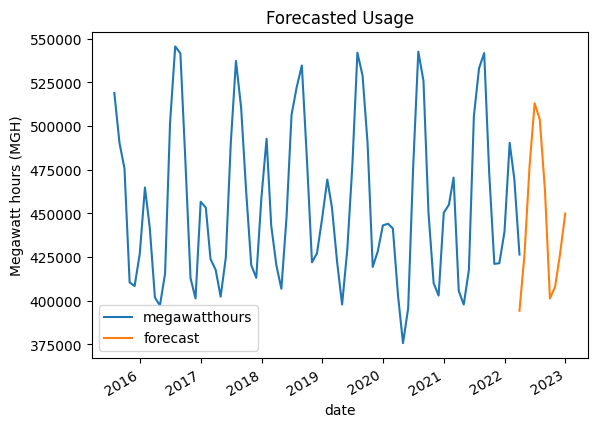

In [64]:
last_date = df_monthly.iloc[-1]["date"]
year = 2023 # @param {type:"integer"}
month = 1 # @param {type:"integer"}

class InvalidMonth(Exception):
  pass
class ValueAlreadyKnown(Exception):
  pass

if month < 1 or month > 12:
  raise InvalidMonth(f"Month must be between 1 and 12. Received {month}.")

if last_date.year > year or (last_date.year == year and last_date.month >= month):
  raise ValueAlreadyKnown(
    f"Actual values are known until {last_date.month}/{last_date.year}. Received prediction request for {month}/{year}."
  )

total_months = (year - last_date.year) * 12 + (month - last_date.month)

future_dates = [df_monthly.iloc[-1]["date"] + DateOffset(months=x) for x in range(0, total_months)]
df_future = pd.DataFrame(columns=df_monthly.columns)
df_future["date"] = future_dates

df_future.tail()

df_prediction = pd.concat([df_monthly, df_future]).set_index("date").reset_index()
df_prediction["forecast"] = model_fit.predict(start=len(df_monthly), end=len(df_monthly) + total_months)

if total_months < 2:
  print("Skipping plot of single data point")
else:
  df_prediction.plot(title="Forecasted Usage", x="date", ylabel="Megawatt hours (MGH)")

print(f"FORECAST: {df_prediction.iloc[-1]['forecast']} MWh for month of {month}/{year}")